# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [49]:
# import libraries
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
import time

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.pipeline import Pipeline
#TfidfVectorizer = CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score
import pickle

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/minyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/minyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/minyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
# load data from database

### 
# create a database engine 
# to find the correct file path, use the python os library:
# import os
# print(os.getcwd())
#
###

engine = create_engine('sqlite:////Users/minyan/Desktop/Python_Project/Data_Courses/DSND_Term2-master/Project3DataPipeline/workspace/data/DisasterResponse.db')
#list table names in the database
engine.table_names()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  del sys.path[0]


['Message', 'data/DisasterResponse.db']

In [51]:
df=pd.read_sql_table('Message',con=engine)

In [52]:
df.head()

,index,id,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.shape

(26216, 41)

In [54]:
X=df['message']
Y = df.iloc[ : , -36:]
category_name = Y.columns
X[9]

'I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )'

In [55]:
Y.dtypes

related                   int64
request                   int64
offer                     int64
aid_related               int64
medical_help              int64
medical_products          int64
search_and_rescue         int64
security                  int64
military                  int64
child_alone               int64
water                     int64
food                      int64
shelter                   int64
clothing                  int64
money                     int64
missing_people            int64
refugees                  int64
death                     int64
other_aid                 int64
infrastructure_related    int64
transport                 int64
buildings                 int64
electricity               int64
tools                     int64
hospitals                 int64
shops                     int64
aid_centers               int64
other_infrastructure      int64
weather_related           int64
floods                    int64
storm                     int64
fire    

In [56]:
for col in category_name:
    print(f'{df[col].name}{df[col].unique()}')

related[1 0 2]
request[0 1]
offer[0 1]
aid_related[0 1]
medical_help[0 1]
medical_products[0 1]
search_and_rescue[0 1]
security[0 1]
military[0 1]
child_alone[0]
water[0 1]
food[0 1]
shelter[0 1]
clothing[0 1]
money[0 1]
missing_people[0 1]
refugees[0 1]
death[0 1]
other_aid[0 1]
infrastructure_related[0 1]
transport[0 1]
buildings[0 1]
electricity[0 1]
tools[0 1]
hospitals[0 1]
shops[0 1]
aid_centers[0 1]
other_infrastructure[0 1]
weather_related[0 1]
floods[0 1]
storm[0 1]
fire[0 1]
earthquake[0 1]
cold[0 1]
other_weather[0 1]
direct_report[0 1]


In [57]:
Y = Y.drop(['related','child_alone'],axis=1)


In [58]:
category_name = Y.columns

Text(0.5, 1.0, 'Distribution of Disaster Response Type')

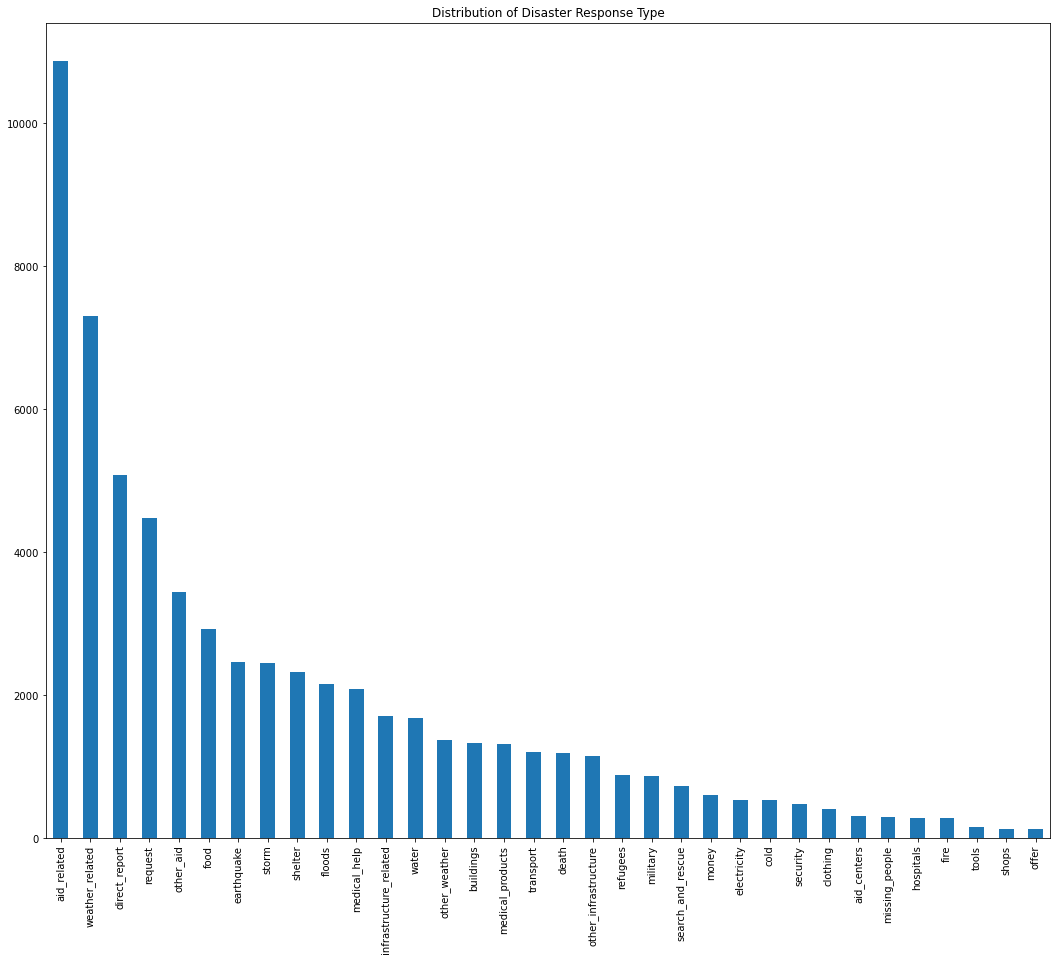

In [59]:
#a quick look of disaster response cetegory plot
plt.figure(figsize=(18,15))
Y.sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of Disaster Response Type")

### 2. Write a tokenization function to process your text data

In [60]:
def p_tokenize(text):
    '''
    INPUT:
        text:raw message
    OUTPUT:
        X:tokenized words
    DESCRIPTION:
        The dunction is to process the scentence, normalize texts, tokenize texts.
        Convert all cases to lower cases, remove extra space,stop words, and 
        reduce words to their root form.
    '''
    clean_tokens=[]    
    #remove punctuation,normalize case to lower cases, and remove extra space
    text = re.sub(r"[^a-zA-Z0-9]"," ",text.lower()).strip()
    
    #tokenize text
    tokens=word_tokenize(text)
    
    
    for w in tokens:  
        #remove stop words
        if w not in stopwords.words("english"):
        #lemmatization
        #reduce words to their root form
            lemmed = WordNetLemmatizer().lemmatize(w)
            clean_tokens.append(lemmed)
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [74]:
pipeline = Pipeline([
        ('tfidvectorizer', TfidfVectorizer(tokenizer=p_tokenize)),#override the tokenizer with customized one
        ('clf', MultiOutputClassifier(SGDClassifier(n_jobs = -1,random_state=6)))])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=6)

In [76]:
X_train

794      was. Please Help me! ( end of last message I t...
24856    With respect to the security challenges, the r...
7333     Is it a good thing when someone uses insectici...
12058    RT andatopaz: Se o pessoal de SANTA CRUZ for t...
18284    WFP 43,053 MT of Food Assistance (soy fortifie...
                               ...                        
8527     when they will restart with the identification...
4714     WHERE CAN I HAVE MY PASSPORT MADE ? I NEVER HA...
10196    Haiti And Earthquake Disaster! Watch Haiti and...
8419     reactions. -3-Contractille it is the property ...
19145    Such optimism is premature, given the HCUA con...
Name: message, Length: 20972, dtype: object

In [77]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidvectorizer',
                 TfidfVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>)),
                ('clf',
                 MultiOutputClassifier(estimator=SGDClassifier(n_jobs=-1,
                                                               random_state=6)))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [78]:
Y_test_pred=pipeline.predict(X_test)
print(Y_test_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 1]]


In [79]:
Y_test_pred = pd.DataFrame(data=Y_test_pred, 
                          index=Y_test.index, 
                          columns=category_name)

In [80]:
len(category_name)

34

In [81]:
# from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred,target_names=category_name))

                        precision    recall  f1-score   support

               request       0.77      0.53      0.63       848
                 offer       0.00      0.00      0.00        28
           aid_related       0.77      0.68      0.72      2159
          medical_help       0.68      0.15      0.24       402
      medical_products       0.75      0.23      0.36       248
     search_and_rescue       0.67      0.08      0.14       156
              security       0.00      0.00      0.00        96
              military       0.72      0.12      0.21       169
                 water       0.76      0.59      0.66       313
                  food       0.78      0.71      0.74       571
               shelter       0.83      0.52      0.64       466
              clothing       0.72      0.42      0.54        80
                 money       1.00      0.02      0.05       126
        missing_people       1.00      0.01      0.03        67
              refugees       0.63      

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
print(accuracy_score(Y_test, Y_test_pred))

0.43039664378337145


### 6. Improve your model
Use grid search to find better parameters. 

In [83]:
pipeline.get_params()

{'memory': None,
 'steps': [('tfidvectorizer',
   TfidfVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>)),
  ('clf',
   MultiOutputClassifier(estimator=SGDClassifier(n_jobs=-1, random_state=6)))],
 'verbose': False,
 'tfidvectorizer': TfidfVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>),
 'clf': MultiOutputClassifier(estimator=SGDClassifier(n_jobs=-1, random_state=6)),
 'tfidvectorizer__analyzer': 'word',
 'tfidvectorizer__binary': False,
 'tfidvectorizer__decode_error': 'strict',
 'tfidvectorizer__dtype': numpy.float64,
 'tfidvectorizer__encoding': 'utf-8',
 'tfidvectorizer__input': 'content',
 'tfidvectorizer__lowercase': True,
 'tfidvectorizer__max_df': 1.0,
 'tfidvectorizer__max_features': None,
 'tfidvectorizer__min_df': 1,
 'tfidvectorizer__ngram_range': (1, 1),
 'tfidvectorizer__norm': 'l2',
 'tfidvectorizer__preprocessor': None,
 'tfidvectorizer__smooth_idf': True,
 'tfidvectorizer__stop_words': None,
 'tfidvectorizer__strip_accents': None,
 'tfidvecto

In [84]:
parameters = {
        'clf__estimator__alpha': [0.0001,0.001],
        'clf__estimator__penalty':['l2'],
        'clf__estimator__loss':['hinge']
    }

cv = GridSearchCV(pipeline,parameters,cv=3)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [85]:
cv.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidvectorizer',
                                        TfidfVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>)),
                                       ('clf',
                                        MultiOutputClassifier(estimator=SGDClassifier(n_jobs=-1,
                                                                                      random_state=6)))]),
             param_grid={'clf__estimator__alpha': [0.0001, 0.001],
                         'clf__estimator__loss': ['hinge'],
                         'clf__estimator__penalty': ['l2']})

In [86]:
cv.best_score_

0.43019207814502564

In [87]:
cv.best_params_

{'clf__estimator__alpha': 0.001,
 'clf__estimator__loss': 'hinge',
 'clf__estimator__penalty': 'l2'}

In [88]:
print(classification_report(Y_test, Y_test_pred,target_names=category_name))
print(accuracy_score(Y_test, Y_test_pred))

                        precision    recall  f1-score   support

               request       0.77      0.53      0.63       848
                 offer       0.00      0.00      0.00        28
           aid_related       0.77      0.68      0.72      2159
          medical_help       0.68      0.15      0.24       402
      medical_products       0.75      0.23      0.36       248
     search_and_rescue       0.67      0.08      0.14       156
              security       0.00      0.00      0.00        96
              military       0.72      0.12      0.21       169
                 water       0.76      0.59      0.66       313
                  food       0.78      0.71      0.74       571
               shelter       0.83      0.52      0.64       466
              clothing       0.72      0.42      0.54        80
                 money       1.00      0.02      0.05       126
        missing_people       1.00      0.01      0.03        67
              refugees       0.63      

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [61]:
pipeline = Pipeline([
        ('vectorizer', CountVectorizer(tokenizer=p_tokenize)),#override the tokenizer with customized one
        ('tfidf', TfidfTransformer()),
         ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=-1,random_state=6)))])

In [62]:
pipeline.fit(X_train, Y_train)
Y_test_pred=pipeline.predict(X_test)

Y_test_pred = pd.DataFrame(data=Y_test_pred, 
                          index=Y_test.index, 
                          columns=category_name)

In [63]:
pipeline.get_params()

{'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                          random_state=6)))],
 'verbose': False,
 'vectorizer': CountVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                        random_state=6)),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_

In [64]:
parameters = {
        #'vectorizer__ngram__range':((1,1),(1,2)),#the range for a string of n words
        #'tfidf__smooth__idf':(True,False),
        'clf__estimator__n_estimators':[10,50,100,150]
        #'clf__estimator_criterion':['gini','entropy']
    }

In [65]:
cv = GridSearchCV(pipeline,parameters,cv=3)

In [66]:
start=time.time()
cv.fit(X_train, Y_train)
end=time.time()

In [67]:
process=end-start
print(process)

3053.7893290519714


In [68]:
cv.best_score_

0.41035630182467037

In [69]:
cv.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('vectorizer',
   CountVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                          random_state=6)))],
 'estimator__verbose': False,
 'estimator__vectorizer': CountVectorizer(tokenizer=<function p_tokenize at 0x7f891758e200>),
 'estimator__tfidf': TfidfTransformer(),
 'estimator__clf': MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                        random_state=6)),
 'estimator__vectorizer__analyzer': 'word',
 'estimator__vectorizer__binary': False,
 'estimator__vectorizer__decode_error': 'strict',
 'estimator__vectorizer__dtype': numpy.int64,
 'estimator__vectorizer__encoding': 'utf-8',
 'estimator__vectorizer__input': 'content',
 'estimator__vectorizer__lowercase': True,
 'est

In [70]:
#get the evaluation on the test dataset
Y_test_pred=cv.predict(X_test)

In [71]:
Y_test_pred = pd.DataFrame(data=Y_test_pred, 
                          index=Y_test.index, 
                          columns=category_name)

In [72]:
Y_test_pred

,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
14724,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
22314,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6958,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18161,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [73]:
print(classification_report(Y_test, Y_test_pred,target_names=category_name))
print(accuracy_score(Y_test, Y_test_pred))

                        precision    recall  f1-score   support

               request       0.79      0.49      0.60       848
                 offer       0.00      0.00      0.00        28
           aid_related       0.75      0.69      0.72      2159
          medical_help       0.67      0.06      0.12       402
      medical_products       0.74      0.08      0.15       248
     search_and_rescue       0.60      0.02      0.04       156
              security       0.25      0.01      0.02        96
              military       0.79      0.07      0.12       169
                 water       0.92      0.34      0.49       313
                  food       0.82      0.58      0.68       571
               shelter       0.82      0.40      0.54       466
              clothing       0.80      0.15      0.25        80
                 money       0.80      0.03      0.06       126
        missing_people       0.00      0.00      0.00        67
              refugees       0.67      

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 9. Export your model as a pickle file

In [38]:
# Create a pickle file for the model
file_name = 'classifier.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(cv, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.